In [2]:
import os
import sys
import random
from ultralytics import YOLO
from IPython.display import Image

# Add the 'src' directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Now we can import your config file
from config import Config

In [3]:
# --- 1. Define Model Path (robust) ---
model_name = 'best.pt'
candidate_paths = [
    os.path.join('..', 'models', 'weights', model_name),                       # ../models/weights/best.pt
    os.path.join('..', Config.MODEL_PHASE2_WEIGHTS),                           # runs/detect/yolov8_phase2_fine/weights/best.pt
    Config.MODEL_PHASE2_WEIGHTS,                                               # relative runs/... (may fail depending on CWD)
    # Ensure REPO_ROOT is defined if you use this line in config.py
    # str(Config.REPO_ROOT / 'models' / 'weights' / model_name)                  # absolute path variant
]

# Find the first existing model path
model_path = next((p for p in candidate_paths if p and os.path.exists(p)), None)

print("Checked model paths:")
for p in candidate_paths:
    # Check existence relative to notebook or use absolute paths if defined
    check_path = p if os.path.isabs(p) else os.path.join(os.path.dirname(os.getcwd()), p)
    print("  ", p, "->", "OK" if os.path.exists(check_path) else "MISSING")


if not model_path:
    # If using relative path for Config.MODEL_PHASE2_WEIGHTS, adjust the error message or logic
    model_path_from_config = os.path.join('..', Config.MODEL_PHASE2_WEIGHTS)
    if os.path.exists(model_path_from_config):
        model_path = model_path_from_config
    else:
        raise FileNotFoundError(f"Model file not found. Checked: {candidate_paths}. Place 'best.pt' in '../models/weights/' or ensure '{model_path_from_config}' exists.")

print("Using model:", model_path)


# --- 2. Define Test Image Path ---

# --- Option A: Test using a random image from the dataset (Commented out) ---
# images_dir = Config.IMAGES_DIR
# if not os.path.isdir(images_dir):
#     raise FileNotFoundError(f"Images dir not found: {images_dir}")
# test_image_name = random.choice(os.listdir(images_dir))
# image_path = os.path.join(images_dir, test_image_name)
# print("Using image:", image_path)

# --- Option B: Test using your specific image ---
test_image_name = 'test/image_Jacket.png'
# Assuming test_salma.jpeg is in the same 'notebooks' folder as this notebook
image_path = os.path.abspath(test_image_name) # Use absolute path
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Your image not found at {image_path}. Make sure '{test_image_name}' is in the 'notebooks' folder.")
print("Using image:", image_path)

Checked model paths:
   ../models/weights/best.pt -> MISSING
   /Users/macm4/repositories/2Phase-Object-Detection/runs/detect/yolov8_phase2_fine/weights/best.pt -> OK
   /Users/macm4/repositories/2Phase-Object-Detection/runs/detect/yolov8_phase2_fine/weights/best.pt -> OK
Using model: /Users/macm4/repositories/2Phase-Object-Detection/runs/detect/yolov8_phase2_fine/weights/best.pt
Using image: /Users/macm4/repositories/2Phase-Object-Detection/notebooks/test/image_Jacket.png


Results saved to /Users/macm4/repositories/2Phase-Object-Detection/runs/detect/predict_phase2_test
Detections: 1
Latency (s) mean=0.0129 p50=0.0128 p95=0.0140 | FPS~77.47
 0: bbox=[0.0, 84.96780395507812, 495.2436218261719, 697.9071655273438], conf=0.216, class=5 (dress)
Saved latency/FPS metrics to: /Users/macm4/repositories/2Phase-Object-Detection/runs/detect/yolov8_phase2_fine/latency_fps.json
Annotated image saved to: /Users/macm4/repositories/2Phase-Object-Detection/runs/detect/predict_phase2_test/image_Jacket.jpg


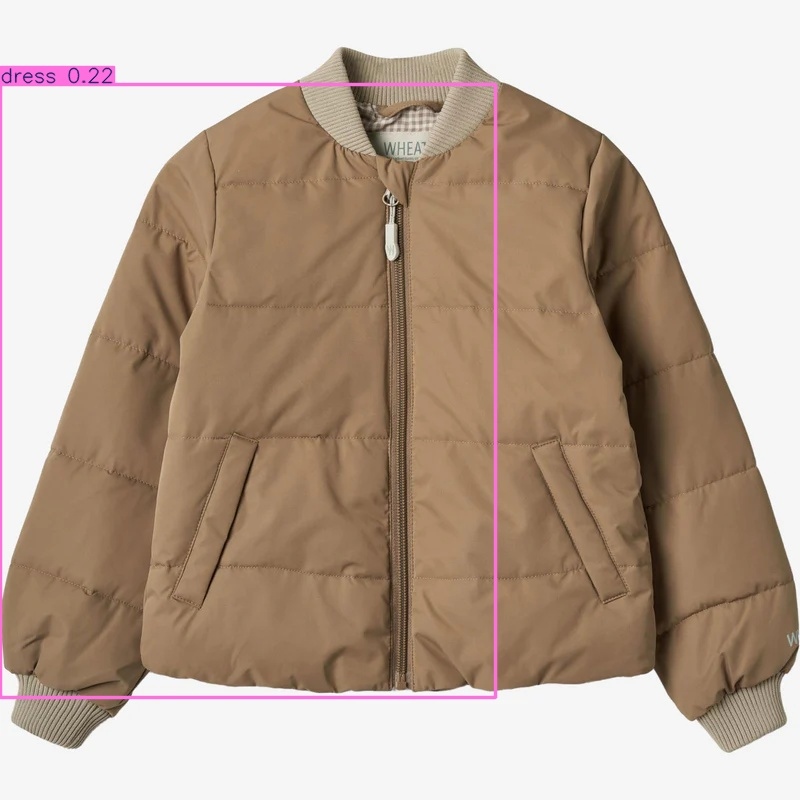

In [6]:
# --- 3. Load model and run prediction with latency/FPS logging ---
import json
import time
from pathlib import Path

import numpy as np

model = YOLO(model_path)

# Inference settings
CONF = 0.2
IOU = 0.45
MAX_DET = 200

def _resolve_training_run_dir(phase_glob: str) -> Path | None:
    matches = sorted(Path('..').glob(phase_glob))
    if matches:
        return matches[-1].resolve()
    return None

# Try to resolve the training run directory to save metrics into
training_run_dir = None
try:
    mp = Path(model_path).expanduser().resolve()
    if mp.parent.name == 'weights' and mp.exists():
        training_run_dir = mp.parent.parent
except Exception:
    training_run_dir = None

if training_run_dir is None or not training_run_dir.exists():
    training_run_dir = _resolve_training_run_dir('runs/detect/yolov8_phase2_fine*')

# 1) Warmup (no save)
_ = model.predict(source=image_path, conf=CONF, iou=IOU, max_det=MAX_DET, save=False, verbose=False)

# 2) Timed runs (no save, avoids disk I/O impacting timing)
N_RUNS = 10
times_s: list[float] = []
for _i in range(N_RUNS):
    t0 = time.perf_counter()
    _ = model.predict(source=image_path, conf=CONF, iou=IOU, max_det=MAX_DET, save=False, verbose=False)
    t1 = time.perf_counter()
    times_s.append(t1 - t0)

times_arr = np.array(times_s, dtype=float)
lat_mean = float(times_arr.mean())
lat_p50 = float(np.percentile(times_arr, 50))
lat_p95 = float(np.percentile(times_arr, 95))
fps_mean = float(1.0 / lat_mean) if lat_mean > 0 else float('inf')

# 3) One run with save=True for visualization/output
# Force outputs into THIS repo (../runs/detect) instead of whatever the current CWD was previously.
project_dir = os.path.abspath(os.path.join('..', 'runs', 'detect'))
results = model.predict(
    source=image_path,
    conf=CONF,
    iou=IOU,
    max_det=MAX_DET,
    save=True,
    project=project_dir,
    name='predict_phase2_test',
    exist_ok=True,
    verbose=False,
)
res = results[0]

n_boxes = len(res.boxes)
print(f"Detections: {n_boxes}")
print(f"Latency (s) mean={lat_mean:.4f} p50={lat_p50:.4f} p95={lat_p95:.4f} | FPS~{fps_mean:.2f}")
if n_boxes == 0:
    print("No boxes detected — try lowering conf or checking model weights.")
else:
    for i, box in enumerate(res.boxes):
        xyxy = box.xyxy[0].cpu().numpy()
        conf = float(box.conf[0].cpu().numpy()) if hasattr(box, 'conf') else None
        cls_id = int(box.cls[0].cpu().numpy()) if hasattr(box, 'cls') else None
        cls_name = model.names[cls_id] if cls_id is not None and cls_id in model.names else str(cls_id)
        print(f" {i}: bbox={xyxy.tolist()}, conf={conf:.3f}, class={cls_id} ({cls_name})")

# Save latency/FPS metrics inside the training run folder (runs/detect/...)
metrics = {
    "phase": "phase2",
    "image": str(image_path),
    "conf": CONF,
    "iou": IOU,
    "max_det": MAX_DET,
    "n_runs": N_RUNS,
    "latency_seconds": {
        "mean": lat_mean,
        "p50": lat_p50,
        "p95": lat_p95,
        "min": float(times_arr.min()),
        "max": float(times_arr.max()),
    },
    "fps": {"mean": fps_mean},
    "detections": int(n_boxes),
}
if training_run_dir is not None:
    try:
        training_run_dir.mkdir(parents=True, exist_ok=True)
        metrics_path = training_run_dir / 'latency_fps.json'
        metrics_path.write_text(json.dumps(metrics, indent=2), encoding='utf-8')
        print("Saved latency/FPS metrics to:", str(metrics_path))
    except Exception as e:
        print("⚠️ Failed to write latency/FPS metrics:", e)
else:
    print("⚠️ Training run dir not found; metrics not written.")

# Show annotated image produced by YOLO
annotated_dir = Path(res.save_dir)
basename = Path(image_path).name
annotated_path = annotated_dir / basename
if not annotated_path.exists():
    # Ultralytics saves by basename; if something changed, fall back to glob search.
    candidates = sorted(annotated_dir.glob(f"*{Path(basename).stem}*"))
    if candidates:
        annotated_path = candidates[0]

print("Annotated image saved to:", str(annotated_path))

from IPython.display import Image, display
display(Image(filename=str(annotated_path)))

Visualizing results from: ../runs/detect/yolov8_phase2_fine


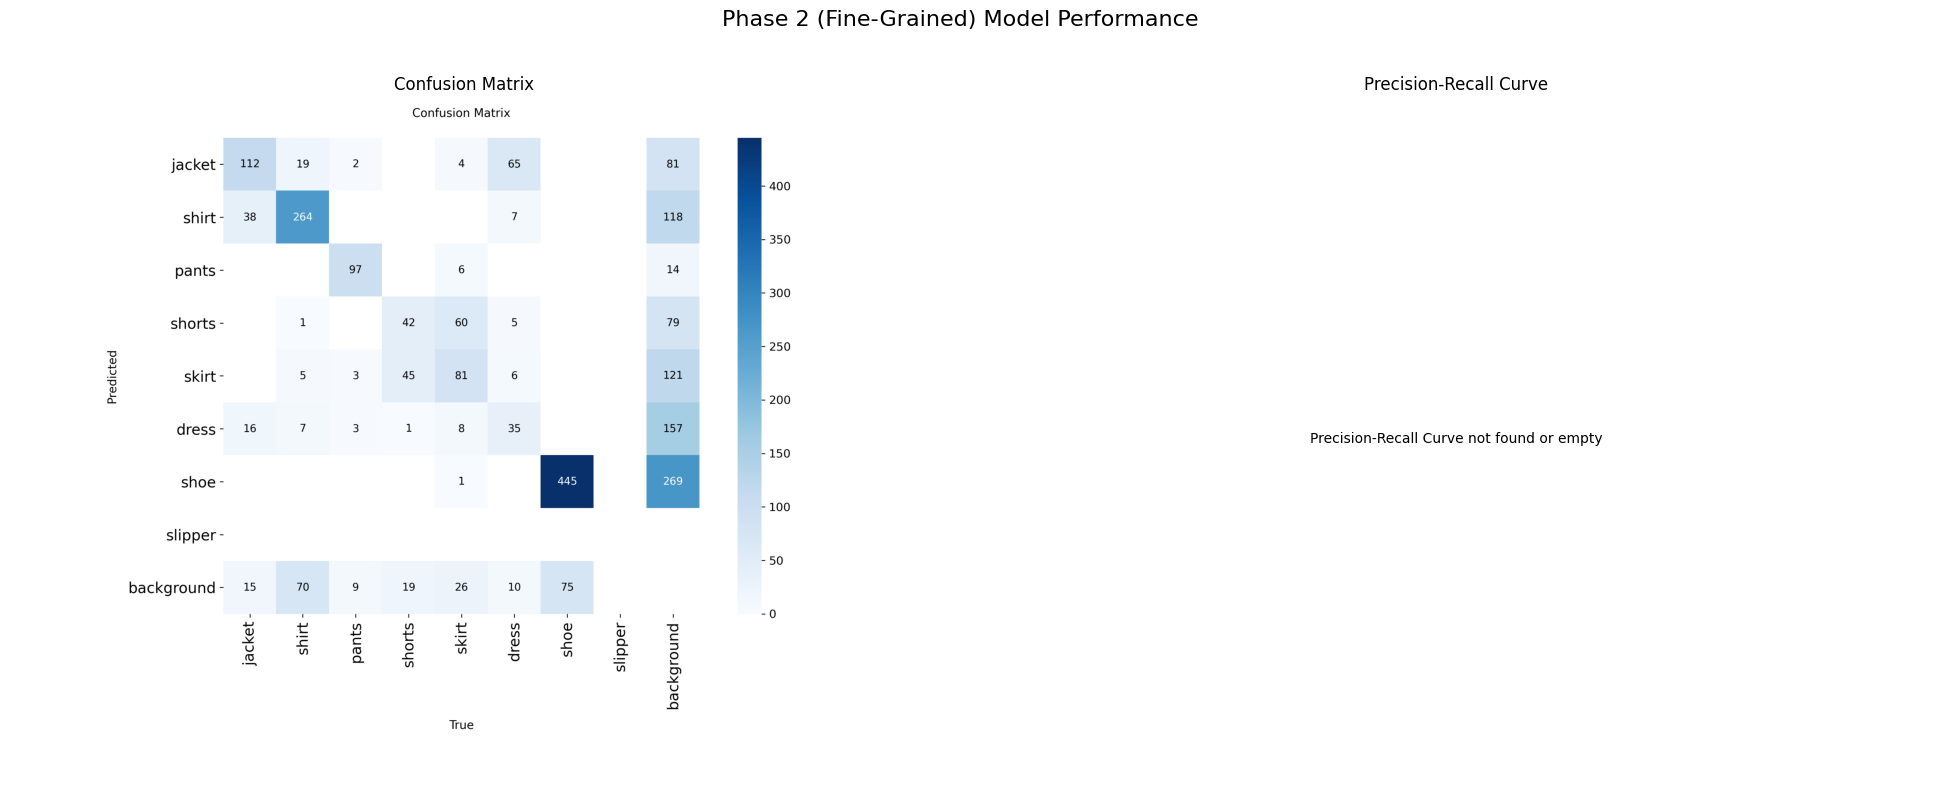

In [5]:
import os
from glob import glob

import cv2
import matplotlib.pyplot as plt

# --- 📊 Visualize Phase 2 Results (robust) ---
run_matches = sorted(glob(os.path.join('..', 'runs', 'detect', 'yolov8_phase2_fine*')))
if not run_matches:
    print("⚠️ No Phase 2 runs found in ../runs/detect/. Skipping visualization.")
else:
    phase2_run_dir = run_matches[-1]
    print(f"Visualizing results from: {phase2_run_dir}")

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle('Phase 2 (Fine-Grained) Model Performance', fontsize=16)

    def safe_show(ax, img_filename, title):
        img_path = os.path.join(phase2_run_dir, img_filename)
        loaded = False
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                try:
                    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                    loaded = True
                except cv2.error:
                    loaded = False

        if not loaded:
            ax.text(0.5, 0.5, f'{title} not found or empty', ha='center', va='center')

        ax.set_title(title)
        ax.axis('off')

    safe_show(axes[0], 'confusion_matrix.png', 'Confusion Matrix')
    safe_show(axes[1], 'PR_curve.png', 'Precision-Recall Curve')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()